This notebook is used to analyze the audit data when the provider either uses the faitful policy $\pi_0$ or when the provider uses a random policy. We unify these two cases since a random policy effectively increases the value of $E$ by a constant amount equal to $I(\pi)$ at each time step.

In [ ]:
%matplotlib inline

import pickle
from transformers import AutoTokenizer, AutoModelForCausalLM

import os
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import numpy as np
from IPython.display import clear_output
os.chdir("../")
from matplotlib.patches import Patch
from src import utils
from matplotlib.lines import Line2D
from matplotlib.ticker import PercentFormatter
palette = sns.color_palette("Set2")

#Create color dic for all 3 models
color_dic = {"L1B": palette[0], "M8B": palette[1], "G1B": palette[2]}

# Load data


In [ ]:
model = "M8B"



#Aggregate all data into a single object

data_1 = []

if model == "G1B":

    for idx in [1, 401, 801, 1201, 1601, 2001, 2801, 3201, 3601]:

        with open(f"outputs/audit_faithfull/audit_faithful_{model}_temp_1.0_poi_7.0_geo_None_id_{idx}.pkl", "rb") as f:
            data_temp = pickle.load(f)
            data_1= data_1 + data_temp
            clear_output()
            
    data_115 = []

    for idx in [1, 401, 801, 1201, 1601, 2401, 2801, 3201, 3601]:

        with open(f"outputs/audit_faithfull/audit_faithful_{model}_temp_1.15_poi_7.0_geo_None_id_{idx}.pkl", "rb") as f:
            data_temp = pickle.load(f)
            data_115= data_115 + data_temp
            clear_output()
            
    data_13 = []

    for idx in [1, 401, 801, 1201, 1601, 2401, 2801, 3201, 3601]:

        with open(f"outputs/audit_faithfull/audit_faithful_{model}_temp_1.3_poi_7.0_geo_None_id_{idx}.pkl", "rb") as f:
            data_temp = pickle.load(f)
            data_13= data_13 + data_temp
            clear_output()
            
            
            
else:
    for idx in [1, 401, 801, 1201, 1601, 2001, 2801, 3201, 3601]:

        with open(f"outputs/audit_faithfull/audit_faithful_{model}_temp_1.0_poi_7.0_geo_None_id_{idx}.pkl", "rb") as f:
            data_temp = pickle.load(f)
            data_1= data_1 + data_temp
            clear_output()
            
    data_115 = []

    for idx in [1, 401, 801, 1201, 1601, 2001, 2801, 3201, 3601]:

        with open(f"outputs/audit_faithfull/audit_faithful_{model}_temp_1.15_poi_7.0_geo_None_id_{idx}.pkl", "rb") as f:
            data_temp = pickle.load(f)
            data_115= data_115 + data_temp
            clear_output()
            
    data_13 = []

    for idx in [1, 401, 801, 1201, 1601, 2001, 2801, 3201, 3601]:

        with open(f"outputs/audit_faithfull/audit_faithful_{model}_temp_1.3_poi_7.0_geo_None_id_{idx}.pkl", "rb") as f:
            data_temp = pickle.load(f)
            data_13= data_13 + data_temp
            clear_output()
    
#Note that the loaded data is a sequence where each element is a dictionary with the following keys:
# 
#             "prompt": The original prompt text,
#             "original": Is a dictionary {"tokens": reference_tokens, "text": reference_text} with the original model output,
#             "unbiased_length": Is the unbiased estimated of the length conditioned on the generated string,
#         
    
    

#Compute all E values
difs_1 = [-d["unbiased_length"] + len(d["original"]["tokens"])   for d in data_1]
difs_115 = [-d["unbiased_length"] + len(d["original"]["tokens"])   for d in data_115]
difs_13 = [-d["unbiased_length"] + len(d["original"]["tokens"])   for d in data_13]



#Remove outiers based on percentiles
p1_1, p99_1 = np.percentile(difs_1, [1, 99])
p1_115, p99_115 = np.percentile(difs_115, [1, 99])
p1_13, p99_13 = np.percentile(difs_13, [1, 99])

difs_1 = [d for d in difs_1 if d >= p1_1 and d <= p99_1]
difs_115 = [d for d in difs_115 if d >= p1_115 and d <= p99_115]
difs_13 = [d for d in difs_13 if d >= p1_13 and d <= p99_13]


# Audit faitful providers
Here, we run the audit when the provider is faitful

In [ ]:


#Temperature ti anaylyze
temp = 1.0

#Compute the lambda parameter based on max E values

lamb_1 = 0.9/(np.max(np.abs([i for i in difs_1])))
lamb_115 = 0.9/(np.max(np.abs([i for i in difs_115])))
lamb_13 = 0.9/(np.max(np.abs([i for i in difs_13])))




if temp == 1.0:
    difs = difs_1
    lamb = lamb_1
elif temp == 1.15:
    difs = difs_115
    lamb = lamb_115
elif temp == 1.3:
    difs = difs_13
    lamb = lamb_13
    
    



plt.clf()
sns.set_theme(context='paper', style='ticks', font_scale=1)
width_pt = 469
palette = sns.color_palette('husl', 4)

utils.latexify()

fig_width, fig_height = utils.get_fig_dim(width_pt, fraction=0.6)

# ---- create two axes (y-axis broken) ----
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True,
                               figsize=(fig_width, fig_height),
                               gridspec_kw={'height_ratios': [1, 2]})
fig.subplots_adjust(hspace=0.05)  # space between



#Number of processes and length of each process
num_process = 30
proc_length = 100

for process in range(num_process):
    grow = False
    M = [1]
    for i in range(proc_length):
        #Evolve the process based on E values
        M.append(M[i] * (1 + lamb * ( difs[process * proc_length + i] )))
    

    ax1.plot(M, color=color_dic[model], alpha=0.3)
    ax2.plot(M, color=color_dic[model], alpha=0.3)

# Add horizontal line at y=20 (only in top plot)
ax1.axhline(y=20, color="red", linestyle='--', alpha=1)

# Axis limits
ax2.set_ylim(-0.1, 13)   # zoomed-in bottom region
ax1.set_ylim(19, 21)    # narrow region around y=20
ax2.set_xlim(-1, proc_length)

# Labels
ax2.set_xlabel(r'Time step, $i$')

# Hide spines and add diagonal cut marks
ax1.spines.bottom.set_visible(False)
ax2.spines.top.set_visible(False)
ax1.xaxis.tick_top()
ax1.tick_params(labeltop=False)  
ax2.xaxis.tick_bottom()

d = .5  # slope of cut lines
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax1.plot([0], [0], transform=ax1.transAxes, **kwargs)  # left break mark on top axis
ax2.plot([0], [1], transform=ax2.transAxes, **kwargs)  # left break mark on bottom axis

sns.despine(ax=ax1, bottom=True)
sns.despine(ax=ax2, top=True)
ax1.set_ylabel("")
ax1.set_yticks([20])
ax1.set_yticklabels(["20"])
ax1.tick_params(labelbottom=False, bottom=False)
ax2.set_yticks([0, 4, 8,12])
ax2.set_yticklabels(["0", "4", "8", "12"])
fig.supylabel(r'Test process, $M$')
ax2.set_xticks([0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])


ax2.set_yticklabels([])
ax2.set_ylabel("")
ax1.set_yticklabels([])
ax1.set_ylabel("")
fig.supylabel('')
plt.show()


# Audit random policy
 Here, we audit a provider who uses the random policy that splits $m$ random tokens. Effectively, this increases $E$ by the intensity $I(\pi)=m$.

stopping_times:  [26, 33, 49, 30, 31, 31, 35, 33, 33, 31, 28, 33, 28, 24, 25, 31, 31, 30, 35, 36, 30, 32, 31, 38, 29, 27, 32, 32, 24, 31, 30, 30, 33, 26, 32, 33, 19, 27, 28, 29, 32, 32, 28, 28, 31, 31, 32, 26, 30, 31, 32, 32, 29, 30, 31, 28, 32, 32, 32, 32, 30, 31, 29, 31, 27, 30, 28, 30, 29, 26, 32, 28, 30, 23, 31, 30, 29, 32, 30, 29, 30, 32, 26, 28, 27, 32, 32, 28, 32, 29, 33, 32, 30, 30, 29, 30, 28, 29, 34, 29, 31, 28, 29, 26, 31, 32, 30, 30, 29, 36, 27, 31, 29, 31, 27, 29, 29, 29, 27]
stopping_times:  [14, 16, 16, 17, 24, 15, 16, 15, 16, 16, 16, 16, 16, 17, 17, 17, 16, 16, 16, 16, 15, 16, 16, 17, 15, 15, 15, 15, 13, 16, 16, 17, 16, 15, 16, 18, 16, 20, 15, 16, 15, 16, 17, 16, 16, 19, 16, 15, 16, 14, 16, 18, 16, 16, 14, 16, 16, 15, 17, 16, 16, 15, 17, 17, 16, 13, 16, 16, 17, 16, 11, 16, 14, 15, 15, 16, 16, 16, 17, 16, 16, 15, 16, 14, 16, 16, 16, 16, 16, 18, 15, 14, 16, 16, 16, 15, 17, 16, 16, 17, 16, 15, 17, 15, 16, 16, 14, 17, 18, 14, 16, 16, 17, 17, 15, 16, 16, 14, 16, 16, 15, 15, 

<Figure size 640x480 with 0 Axes>

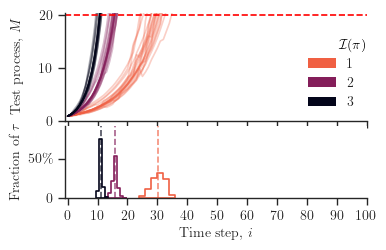

In [ ]:

plt.clf()
sns.set_theme(context='paper', style='ticks', font_scale=1)
width_pt = 469
palette = sns.color_palette('husl', 4)
cmap = sns.color_palette("rocket_r", as_cmap=True)



utils.latexify()

fig_width, fig_height = utils.get_fig_dim(width_pt, fraction=0.6)

# ---- create two axes (y-axis broken) ----
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True,
                               figsize=(fig_width, fig_height),
                               gridspec_kw={'height_ratios': [6, 4]})
fig.subplots_adjust(hspace=0.05)  # space between

#Define the temperature
temp = 1.0

#Intensity values of the policies to analyze, equals to the number of random tokens split m
I_list = [1, 2, 3]

num_process = 30
proc_length = 100

lamb_1 = 0.9/(np.max(np.abs([i for i in difs_1])))
lamb_115 = 0.9/(np.max(np.abs([i for i in difs_115])))
lamb_13 = 0.9/(np.max(np.abs([i for i in difs_13])))

if temp == 1.0:
    difs = difs_1
    lamb = lamb_1

elif temp == 1.15:
    difs = difs_115
    lamb = lamb_115
    
elif temp == 1.3:
    difs = difs_13
    lamb = lamb_13
    



for I in I_list:

    for process in range(num_process):
        M = [1]

        for i in range(proc_length):
            
            #Add the intensity I to the E values
            M.append( M[i] * (1 + lamb * ( I + difs[process * proc_length + i]  )  ) )
        
        #Record the detection (stopping) time
        first_hitting_time = next((index for index, value in enumerate(M) if value >= 20), None)
        if first_hitting_time is not None:
            ax1.plot(M[:first_hitting_time + 1], color=cmap(I/len(I_list)), alpha=0.3)



    stopping_times = []

    total_data = len(difs)

    M = 1

    total_index = 0 
    local_index = 0

    while total_index < total_data:
        total_index += 1
        M = M * (1 + lamb * (I + difs[total_index - 1] ))
        local_index += 1
        if M >= 20:
            stopping_times.append(local_index)
            M = 1
            local_index = 0
            
    stopping_times = np.asarray(stopping_times)

    if I == 1:
        sns.histplot(stopping_times, stat="percent",discrete=False,
                binwidth=2,
                ax=ax2, color=cmap(I/len(I_list)),
                element="step", fill=True, alpha=0,linewidth=1.2
                )    
    else:
        sns.histplot(stopping_times, stat="percent",discrete=True,
                binwidth=2,
                ax=ax2, color=cmap(I/len(I_list)),
                element="step", fill=True, alpha=0,linewidth=1.2
                )
    
    ax2.axvline(np.mean(stopping_times), color=cmap(I/len(I_list)), linestyle='--', alpha=0.7)


# Add horizontal line at y=20 (only in top plot)
ax1.axhline(y=20, color="red", linestyle='--', alpha=1)

# Axis limits
#ax2.set_ylim(0, 31)   # zoomed-in bottom region
ax1.set_ylim(0, 20.3)
ax2.set_xlim(-1, proc_length)

# Labels
ax2.set_xlabel(r'Time step, $i$')


# Hide spines and add diagonal cut marks
ax1.spines.bottom.set_visible(False)
ax2.spines.top.set_visible(False)
ax1.xaxis.tick_top()
ax1.tick_params(labeltop=False)
ax1.tick_params(top=False)  
  
ax2.xaxis.tick_bottom()

ax1.set_ylabel(r"Test process, $M$", labelpad=11.5)

sns.despine(ax=ax1, bottom=False)
sns.despine(ax=ax2, top=True)

ax1.xaxis.tick_bottom()


ax2.set_xticks([0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
ax2.set_ylim(0,91)
ax2.set_yticks([0, 50])
ax2.set_yticklabels([0, r"50\%"])
ax2.set_ylabel(r"Fraction of $\tau$")

legend_handles = []

for j in [1,2,3]:
    color = cmap((j)/3)
    legend_handles.append(Patch(facecolor=color, edgecolor='none', label=j))

ax1.legend(handles=legend_handles, loc='lower right', frameon=False, ncol=1, fontsize=10)
ax1.text(0.95, 0.7, r"$\mathcal{I}(\pi)$", fontsize=10, color='black', ha='center', va='center',transform=ax1.transAxes)





plt.show()
